In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # Gráficos
import seaborn as sns
import statsmodels.api as sm # forecast
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.tsa as tsa

In [128]:
# importando a série histórica desde 1994
sh = pd.read_excel(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\Base Dados RF x RV.xlsx", sheet_name="OneinAll", index_col=0)
shus = pd.read_excel(r"C:\Users\Pohlmann\Documents\FGV\9º Semestre\Fin2\Base Dados RF x RV.xlsx", sheet_name="US", index_col=0)
sh.head()

,CDI_Ano,IBOV,CDI_Dia,IBOV_DIA,CDIB1,IBOVB1
Data,,,,,,
1994-07-01,149.642900,3623.1,0.003637,0.000000,1.000000,1.000000
1994-07-04,172.091812,3580.8,0.003980,-0.011675,1.003980,0.988325
1994-07-05,173.255310,3564.3,0.003997,-0.004608,1.007993,0.983771
1994-07-06,173.461151,3753.5,0.004000,0.053082,1.012025,1.035991
1994-07-07,171.409714,3904.9,0.003970,0.040336,1.016043,1.077779


In [129]:
sh.sort_index(inplace=True)
shus.sort_index(inplace=True)

In [58]:
# Limpando eventuais NaNs e ajustando frequência do índice para business days
sh_clean = sh.dropna(subset=['IBOV'], axis=0).sort_index().asfreq("B", method='ffill')

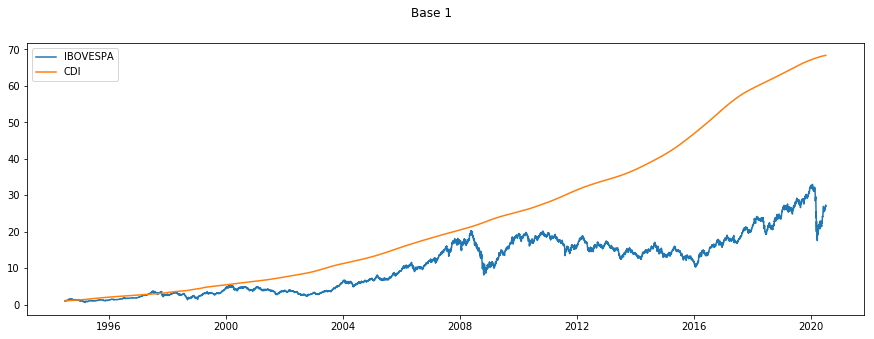

In [85]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sh.IBOVB1, label="IBOVESPA")
ax.plot(sh.CDIB1, label="CDI")
fig.suptitle("Base 1")
leg = ax.legend()

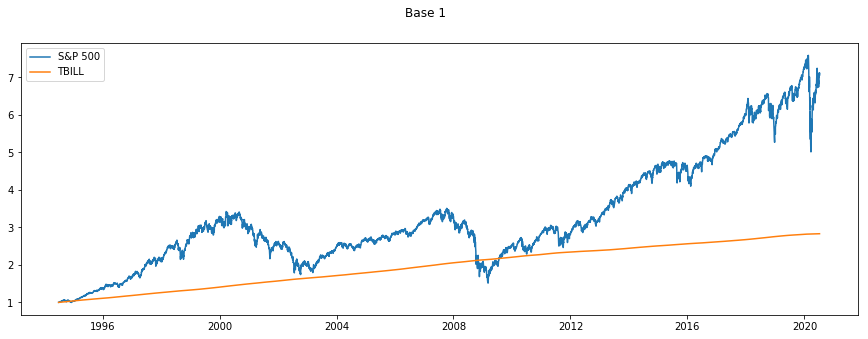

In [131]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(shus.SPXB1, label="S&P 500")
ax.plot(shus.TBILLB1, label="TBILL")
fig.suptitle("Base 1")
leg = ax.legend()

In [144]:
for i in [252, 252*5, 252*10, 252*20]:
    IBOV = pd.DataFrame(sh[i:].reset_index().IBOVB1/sh.reset_index().IBOVB1-1)
    sh['IBOV'+str(i)] = IBOV.set_index(sh.index)
    CDI = pd.DataFrame(sh[i:].reset_index().CDIB1/sh.reset_index().CDIB1-1)
    sh['CDI'+str(i)] = CDI.set_index(sh.index)
    sh['Comparativo'+str(i)] = sh['IBOV'+str(i)]/sh['CDI'+str(i)]-1

In [146]:
for i in [252, 252*5, 252*10, 252*20]:
    SPX = pd.DataFrame(shus[i:].reset_index().SPXB1/shus.reset_index().SPXB1-1)
    shus['SPX'+str(i)] = SPX.set_index(shus.index)
    TBILL = pd.DataFrame(shus[i:].reset_index().TBILLB1/shus.reset_index().TBILLB1-1)
    shus['TBILL'+str(i)] = TBILL.set_index(shus.index)
    shus['Comparativo'+str(i)] = shus['SPX'+str(i)]/shus['TBILL'+str(i)]-1

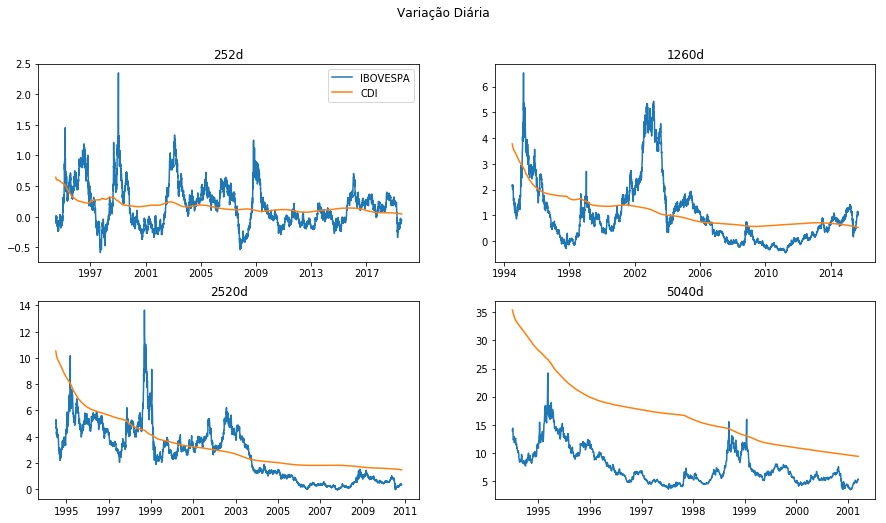

In [145]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].plot(sh.IBOV252, label="IBOVESPA")
ax[0,0].plot(sh.CDI252, label="CDI")
ax[0,0].set_title('252d')

ax[0,1].plot(sh.IBOV1260, label="IBOVESPA")
ax[0,1].plot(sh.CDI1260, label="CDI")
ax[0,1].set_title('1260d')

ax[1,0].plot(sh.IBOV2520, label="IBOVESPA")
ax[1,0].plot(sh.CDI2520, label="CDI")
ax[1,0].set_title('2520d')

ax[1,1].plot(sh.IBOV5040, label="IBOVESPA")
ax[1,1].plot(sh.CDI5040, label="CDI")
ax[1,1].set_title('5040d')

fig.suptitle("Variação Diária")
leg = ax[0,0].legend()

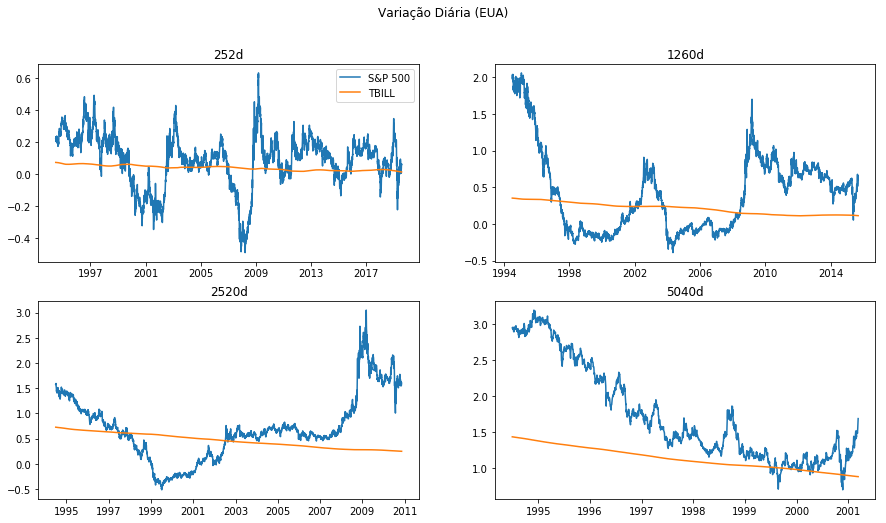

In [147]:
fig, ax = plt.subplots(2,2,figsize=(15,8))
ax[0,0].plot(shus.SPX252, label="S&P 500")
ax[0,0].plot(shus.TBILL252, label="TBILL")
ax[0,0].set_title('252d')

ax[0,1].plot(shus.SPX1260, label="S&P 500")
ax[0,1].plot(shus.TBILL1260, label="TBILL")
ax[0,1].set_title('1260d')

ax[1,0].plot(shus.SPX2520, label="S&P 500")
ax[1,0].plot(shus.TBILL2520, label="TBILL")
ax[1,0].set_title('2520d')

ax[1,1].plot(shus.SPX5040, label="S&P 500")
ax[1,1].plot(shus.TBILL5040, label="TBILL")
ax[1,1].set_title('5040d')

fig.suptitle("Variação Diária (EUA)")
leg = ax[0,0].legend()

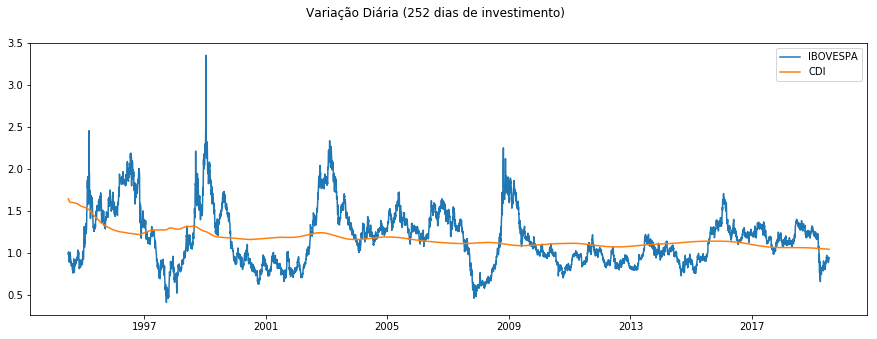

In [118]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(sh.IBOV252, label="IBOVESPA")
ax.plot(sh.CDI252, label="CDI")
fig.suptitle("Variação Diária (252 dias de investimento)")
leg = ax.legend()

### Forecast

In [248]:
a = sh.IBOV_Base100.sort_index().asfreq("d", method='ffill')

In [146]:
b = sh.SELIC_Base100.sort_index().asfreq("w", method='ffill')

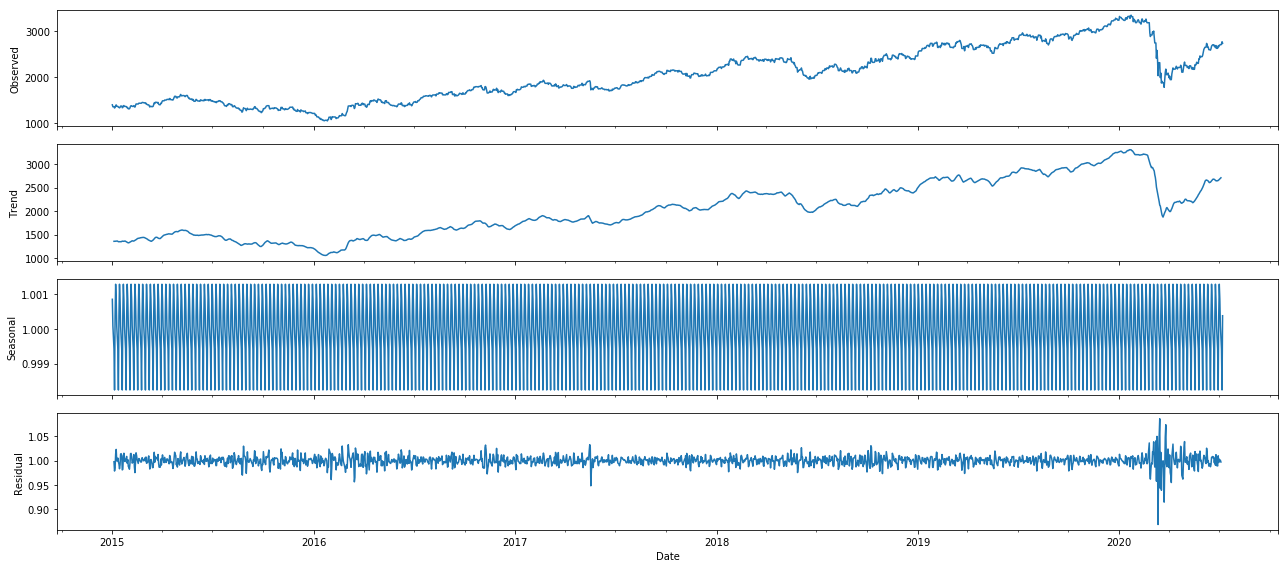

In [249]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(a['2015':], model='multiplicative')
fig = decomposition.plot()
plt.show()

In [258]:
# fit model
model = SARIMAX(a, order=(1, 1, 1), seasonal_order=(1, 1, 1, 90))
model_fit = model.fit(disp=False)
# fit summary
print(model_fit.summary().tables[1])

KeyboardInterrupt: 

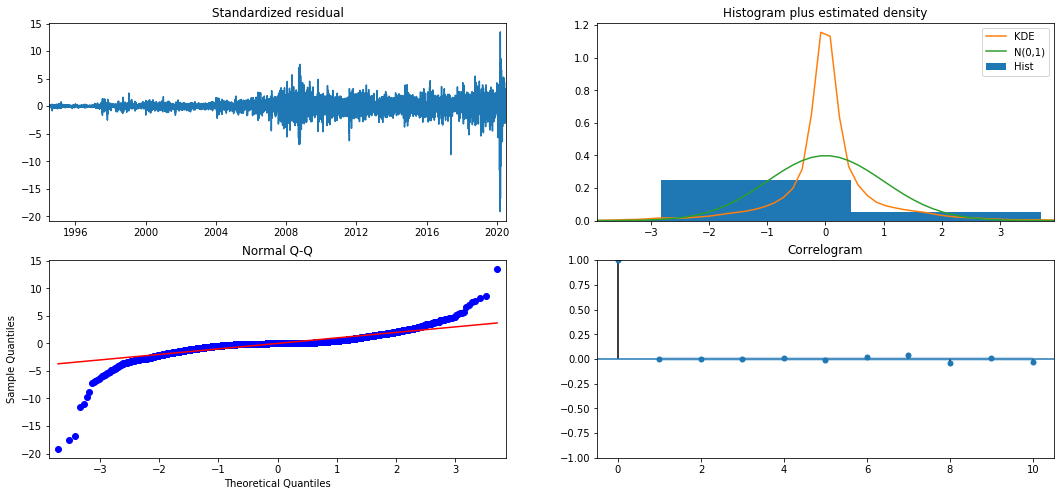

In [251]:
model_fit.plot_diagnostics(figsize=(18, 8))
plt.show()

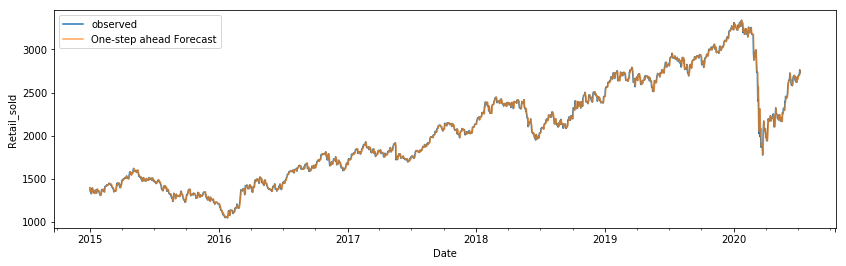

In [252]:
pred = model_fit.get_prediction(dynamic=False)
pred_ci = pred.conf_int()
ax = a['2015':].plot(label='observed')
pred.predicted_mean['2015':].plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

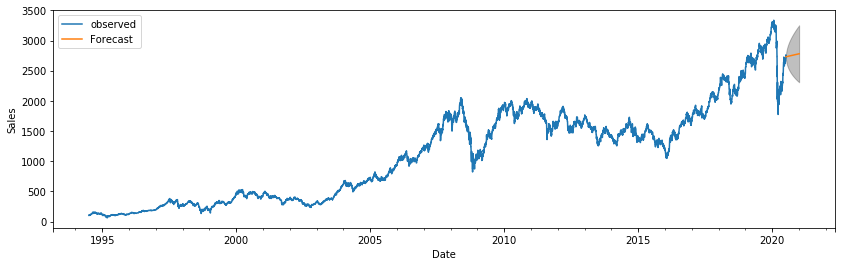

In [254]:
pred_uc = model_fit.get_forecast(steps=180)
pred_ci = pred_uc.conf_int(alpha=0.05)
ax = a.plot(label='observed', figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

In [230]:
pred_uc = model_fit.get_forecast(steps=30)

In [247]:
pred_uc.predicted_mean.head(5)

2020-07-12    2699.565410
2020-07-19    2709.675085
2020-07-26    2712.556741
2020-08-02    2715.066681
2020-08-09    2718.011232
Freq: W-SUN, dtype: float64

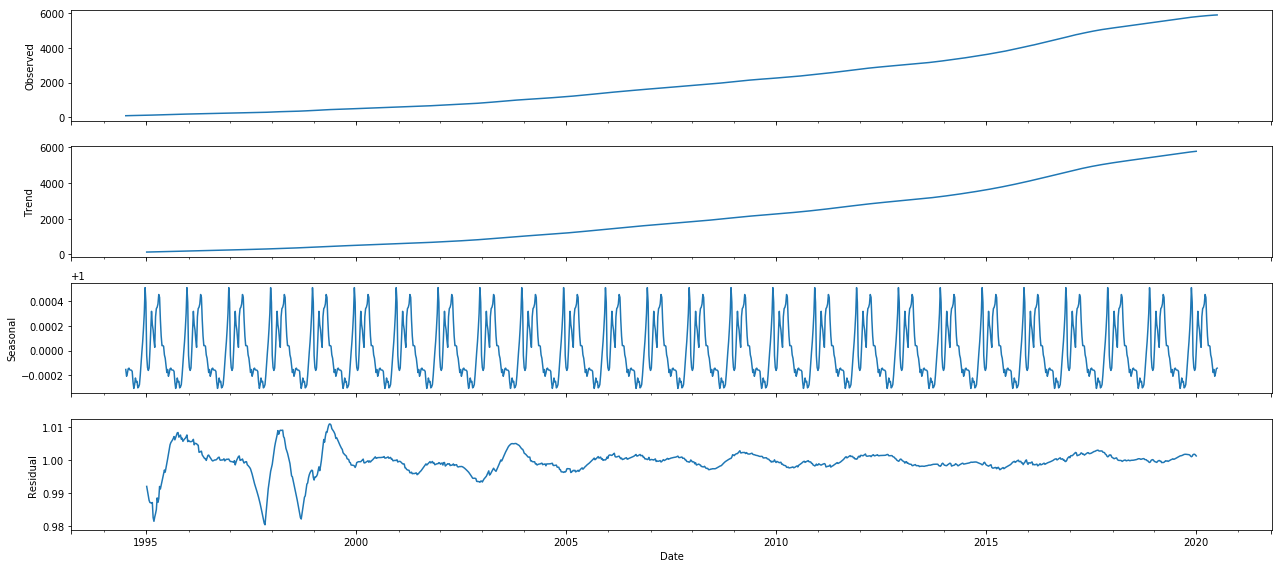

In [147]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(b, model='multiplicative')
fig = decomposition.plot()
plt.show()